In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from surprise import Dataset, Reader, KNNBasic, SVD, accuracy
from surprise.model_selection import cross_validate, train_test_split as surprise_train_test_split
import shap
import lime
import lime.lime_tabular

In [4]:
# file paths
ratings_path = r"C:\Users\vnguno\Desktop\mini-thesis\ml-1m\ratings.dat"
users_path = r"C:\Users\vnguno\Desktop\mini-thesis\ml-1m\users.dat"
movies_path = r"C:\Users\vnguno\Desktop\mini-thesis\ml-1m\movies.dat"

# loading datasets
ratings = pd.read_csv(ratings_path, sep="::", engine='python', names=["UserID", "MovieID", "Rating", "Timestamp"],encoding='ISO-8859-1')
users = pd.read_csv(users_path, sep="::", engine='python', names=["UserID", "Gender", "Age", "Occupation", "Zip-code"], encoding='ISO-8859-1')
movies = pd.read_csv(movies_path, sep="::", engine='python', names=["MovieID", "Title", "Genres"], encoding='ISO-8859-1')

# view the datasets
print("Ratings dataset preview:")
display(ratings.head())

print("\nUsers dataset preview:")
display(users.head())

print("\nMovies dataset preview:")
display(movies.head())

Ratings dataset preview:


UserID  MovieID  Rating  Timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291


Users dataset preview:


UserID Gender  Age  Occupation Zip-code
0       1      F    1          10    48067
1       2      M   56          16    70072
2       3      M   25          15    55117
3       4      M   45           7    02460
4       5      M   25          20    55455


Movies dataset preview:


MovieID                               Title                        Genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy

In [5]:
# dont need 'Timestamp' column
ratings = ratings.drop(columns=["Timestamp"])

# merging datasets 
merged_data = pd.merge(ratings, movies, on='MovieID')

# rename columns to match LensKit expectations
merged_data = merged_data.rename(columns={"UserID": "user", "MovieID": "item", "rating": "Rating"})

display(merged_data.head())

# spliting into training and testing sets (80% training, 20% testing)
train_data, test_data = train_test_split(merged_data, test_size=0.2, random_state=42)

# viewing the sizes of the training and testing sets
display(train_data.shape)
display(test_data.shape)

user  item  Rating                                   Title  \
0     1  1193       5  One Flew Over the Cuckoo's Nest (1975)   
1     1   661       3        James and the Giant Peach (1996)   
2     1   914       3                     My Fair Lady (1964)   
3     1  3408       4                  Erin Brockovich (2000)   
4     1  2355       5                    Bug's Life, A (1998)   

                         Genres  
0                         Drama  
1  Animation|Children's|Musical  
2               Musical|Romance  
3                         Drama  
4   Animation|Children's|Comedy

(800167, 5)

(200042, 5)

In [7]:
from surprise import Dataset, Reader, KNNBasic
from surprise import accuracy
import pandas as pd
from IPython.display import display

reader = Reader(rating_scale=(1, 5))

data_train = Dataset.load_from_df(train_data[['user', 'item', 'Rating']], reader)

# building the training set
trainset = data_train.build_full_trainset()

# Item-KNN algorithm with cosine similarity
sim_options = {
    'name': 'cosine',  # You can also try 'pearson'
    'user_based': False  # Compute similarities between items
}

algo = KNNBasic(sim_options=sim_options)

# train the algorithm on the training set (or test)
algo.fit(trainset)

# print once complete
print("Item-KNN algorithm trained successfully!")

# Prepare test data in the required format for Surprise
testset = list(zip(test_data['user'], test_data['item'], test_data['Rating']))

# make predictions on the test set
predictions = algo.test(testset)

# display a few sample predictions
predictions_df = pd.DataFrame([(pred.uid, pred.iid, pred.r_ui, pred.est) for pred in predictions],
                              columns=['User', 'Item', 'Actual Rating', 'Predicted Rating'])
print("Sample predictions:")
display(predictions_df.head())

# RMSE (Root Mean Squared Error)
rmse = accuracy.rmse(predictions)
print(f'RMSE for Item-KNN: {rmse}')

Computing the cosine similarity matrix...
Done computing similarity matrix.
Item-KNN algorithm trained successfully!
Sample predictions:


User  Item  Actual Rating  Predicted Rating
0  5412  2683              2          4.221532
1  5440   904              5          4.336453
2   368  3717              4          3.747918
3   425  1721              4          3.574863
4  4942  3697              1          3.546092

RMSE: 1.0033
RMSE for Item-KNN: 1.0032545640969515


In [8]:
from collections import defaultdict

# function to calculate precision and recall at k
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    user_est_true = defaultdict(list)
    
    # organize predictions by user
    for pred in predictions:
        user_est_true[pred.uid].append((pred.est, pred.r_ui))

    precisions = {}
    recalls = {}

    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # average precision and recall across all users
    precision_avg = sum(prec for prec in precisions.values()) / len(precisions)
    recall_avg = sum(rec for rec in recalls.values()) / len(recalls)

    return precision_avg, recall_avg

# calculate precision@10 and recall@10
precision, recall = precision_recall_at_k(predictions, k=10, threshold=3.5)

# print results
print(f'precision@10: {precision:.4f}')
print(f'recall@10: {recall:.4f}')


Precision@10: 0.6854
Recall@10: 0.5231


In [9]:
from surprise import SVD

als_algo = SVD()

# train the model on the training set
als_algo.fit(trainset)

print("als algorithm (SVD) trained successfully!")

# make predictions on the test set
als_predictions = als_algo.test(testset)

# display a few sample predictions
als_predictions_df = pd.DataFrame([(pred.uid, pred.iid, pred.r_ui, pred.est) for pred in als_predictions],
                                  columns=['user', 'item', 'actual rating', 'predicted rating'])
print("sample predictions (als):")
display(als_predictions_df.head())

# compute RMSE for the model
als_rmse = accuracy.rmse(als_predictions)

print(f'rmse for als (SVD): {als_rmse}')

# calculate precision@10 and recall@10
als_precision, als_recall = precision_recall_at_k(als_predictions, k=10, threshold=3.5)

print(f'precision@10 (als): {als_precision:.4f}')
print(f'recall@10 (als): {als_recall:.4f}')

ALS algorithm (SVD) trained successfully!
Sample predictions (ALS):


User  Item  Actual Rating  Predicted Rating
0  5412  2683              2          3.013020
1  5440   904              5          5.000000
2   368  3717              4          2.991320
3   425  1721              4          3.231605
4  4942  3697              1          2.581878

RMSE: 0.8774
RMSE for ALS (SVD): 0.8773942633034035
Precision@10 (ALS): 0.7831
Recall@10 (ALS): 0.5447


In [15]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# convert genres to a feature vector (tf-idf)
tfidf = TfidfVectorizer(token_pattern=r'[^|]+')
tfidf_matrix = tfidf.fit_transform(movies['Genres'])

# calculate cosine similarity between all movies
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# function to recommend movies based on genre similarity
def content_based_recommendations(user_id, n_recommendations=10):
    user_ratings = merged_data[merged_data['user'] == user_id].sort_values(by='Rating', ascending=False)
    recommendations = pd.DataFrame()

    for _, row in user_ratings.iterrows():
        movie_id = row['item']
        movie_idx = movies[movies['MovieID'] == movie_id].index[0]
        sim_scores = list(enumerate(cosine_sim[movie_idx]))  
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:]
        top_similar_movies = [movies['MovieID'].iloc[i[0]] for i in sim_scores[:n_recommendations]]
        recommendations = pd.concat([recommendations, movies[movies['MovieID'].isin(top_similar_movies)]])
    
    return recommendations.drop_duplicates().head(n_recommendations)

# example of getting content-based recommendations for a user
user_id = 5412
recommended_movies = content_based_recommendations(user_id)

# display recommended movies
print(f"recommended movies for user {user_id} based on content similarity:")
display(recommended_movies[['Title', 'Genres']])


Recommended movies for user 5412 based on content similarity:


Title           Genres
93                 Broken Arrow (1996)  Action|Thriller
96                     Shopping (1994)  Action|Thriller
163  Die Hard: With a Vengeance (1995)  Action|Thriller
285        Natural Born Killers (1994)  Action|Thriller
372             River Wild, The (1994)  Action|Thriller
397                      Mirage (1995)  Action|Thriller
419                  Blown Away (1994)  Action|Thriller
453               Fugitive, The (1993)  Action|Thriller
470         In the Line of Fire (1993)  Action|Thriller
490          Executive Decision (1996)  Action|Thriller

In [18]:
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# precompute the top-N most similar movies (limiting to top 20)
top_n_similar_movies = 20
cosine_sim_top_n = np.argsort(-cosine_sim, axis=1)[:, 1:top_n_similar_movies+1]

# function to predict ratings using precomputed similarities
def predict_rating_optimized(user_id, movie_id):
    user_ratings = merged_data[merged_data['user'] == user_id]
    movie_idx = movies[movies['MovieID'] == movie_id].index[0]
    similar_movies = cosine_sim_top_n[movie_idx]

    rated_similar_movies = user_ratings[user_ratings['item'].isin(movies['MovieID'].iloc[similar_movies])]
    
    if rated_similar_movies.empty:
        return merged_data['Rating'].mean()

    weighted_sum = 0
    sim_sum = 0
    for _, row in rated_similar_movies.iterrows():
        other_movie_idx = movies[movies['MovieID'] == row['item']].index[0]
        similarity = cosine_sim[movie_idx, other_movie_idx]
        weighted_sum += similarity * row['Rating']
        sim_sum += similarity
    
    return weighted_sum / sim_sum if sim_sum != 0 else merged_data['Rating'].mean()

# calculate RMSE for optimized content-based filtering
def compute_rmse_optimized():
    predictions = []
    actuals = []

    for _, row in test_data.iterrows():
        predicted_rating = predict_rating_optimized(row['user'], row['item'])
        predictions.append(predicted_rating)
        actuals.append(row['Rating'])
    
    # display sample predictions
    predictions_df = pd.DataFrame({'User': test_data['user'], 'Item': test_data['item'], 
                                   'Actual Rating': actuals, 'Predicted Rating': predictions})
    print("sample predictions (optimized):")
    display(predictions_df.head())

    return np.sqrt(mean_squared_error(actuals, predictions))

# calculate RMSE for content-based filtering
rmse_content_based_optimized = compute_rmse_optimized()
print(f"rmse for optimized content-based filtering: {rmse_content_based_optimized:.4f}")


Sample predictions (Optimized):


User  Item  Actual Rating  Predicted Rating
895536  5412  2683              2          3.581564
899739  5440   904              5          5.000000
55687    368  3717              4          3.602685
63727    425  1721              4          3.581564
822011  4942  3697              1          2.985222

RMSE for Optimized Content-Based Filtering: 1.0270


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Step 1: Define a function to predict ratings based on content similarity
def predict_rating(user_id, movie_id, cosine_sim):
    user_ratings = merged_data[merged_data['user'] == user_id][['item', 'Rating']]
    movie_idx = movies[movies['MovieID'] == movie_id].index[0]

    # Retrieve all similarities for the target movie
    sim_scores = cosine_sim[movie_idx]

    # Filter rated movies
    rated_items_idx = movies[movies['MovieID'].isin(user_ratings['item'])].index
    similarities = sim_scores[rated_items_idx]

    # Get the ratings for those movies
    ratings = user_ratings.set_index('item').loc[movies['MovieID'].iloc[rated_items_idx]]['Rating'].values

    # Compute weighted sum of ratings based on similarity
    if len(ratings) == 0 or np.sum(similarities) == 0:
        return merged_data['Rating'].mean()  # fallback to average rating

    return np.dot(similarities, ratings) / np.sum(similarities)

# Step 2: Calculate RMSE for content-based filtering
def compute_rmse():
    predictions = []
    actuals = []

    for _, row in test_data.iterrows():
        predicted_rating = predict_rating(row['user'], row['item'], cosine_sim)
        predictions.append(predicted_rating)
        actuals.append(row['Rating'])
    
    predictions_df = pd.DataFrame({
        'User': test_data['user'], 
        'Item': test_data['item'], 
        'Actual Rating': actuals, 
        'Predicted Rating': predictions
    })
    
    # Display sample predictions
    print("Sample predictions:")
    display(predictions_df.head())

    return np.sqrt(mean_squared_error(actuals, predictions))

# Step 3: Compute Precision@K and Recall@K for content-based filtering
def precision_recall_content_based_at_k(user_id, k=10, threshold=3.5):
    user_ratings = merged_data[merged_data['user'] == user_id].sort_values(by='Rating', ascending=False)

    # Precompute the top-k movie recommendations
    recommendations = []
    for _, row in user_ratings.iterrows():
        movie_id = row['item']
        movie_idx = movies[movies['MovieID'] == movie_id].index[0]
        
        sim_scores = cosine_sim[movie_idx]
        top_k_movies_idx = np.argsort(-sim_scores)[1:k+1]
        recommendations.extend(movies['MovieID'].iloc[top_k_movies_idx])

    recommendations = set(recommendations)

    # Compare recommendations with test set
    user_test_data = test_data[test_data['user'] == user_id]
    hits = len(set(user_test_data['item']).intersection(recommendations))

    precision = hits / k if k != 0 else 0
    recall = hits / len(user_test_data) if len(user_test_data) != 0 else 0

    return precision, recall

# Step 4: Run and evaluate
rmse_content_based = compute_rmse()
print(f"RMSE for Content-Based Filtering: {rmse_content_based:.4f}")

user_id = 5412  # example user
precision_cb, recall_cb = precision_recall_content_based_at_k(user_id, k=10, threshold=3.5)

print(f"Precision@10 for Content-Based Filtering: {precision_cb:.4f}")
print(f"Recall@10 for Content-Based Filtering: {recall_cb:.4f}")


In [19]:
# calculate precision@10 and recall@10 for user
user_id = 5412  # example user
precision_cb, recall_cb = precision_recall_content_based_at_k(user_id, k=10, threshold=3.5)

print(f"precision@10 for content-based filtering: {precision_cb:.4f}")
print(f"recall@10 for content-based filtering: {recall_cb:.4f}")

Precision@10 for Content-Based Filtering: 2.9000
Recall@10 for Content-Based Filtering: 0.4531


In [21]:
# function to calculate precision@k and recall@k for a single user
def precision_recall_optimized_at_k(user_id, k=10, threshold=3.5):
    user_ratings = merged_data[merged_data['user'] == user_id].sort_values(by='Rating', ascending=False)
    user_test_data = test_data[test_data['user'] == user_id]
    
    recommendations = pd.DataFrame()

    # recommend movies based on the user's highly rated movies
    for _, row in user_ratings.iterrows():
        movie_id = row['item']
        movie_idx = movies[movies['MovieID'] == movie_id].index[0]
        sim_scores = cosine_sim_top_n[movie_idx]
        top_similar_movies = [movies['MovieID'].iloc[i] for i in sim_scores[:k]]
        recommendations = pd.concat([recommendations, movies[movies['MovieID'].isin(top_similar_movies)]])
    
    # keep top-k recommendations and remove duplicates
    recommendations = recommendations.drop_duplicates().head(k)

    # calculate precision and recall
    hits = sum([1 for _, row in user_test_data.iterrows() if row['item'] in recommendations['MovieID'].values])
    precision = hits / k if k != 0 else 0
    recall = hits / len(user_test_data) if len(user_test_data) != 0 else 0
    
    return precision, recall

# function to compute precision@k and recall@k for all users
def precision_recall_optimized_all_users(k=10, threshold=3.5):
    precisions = []
    recalls = []
    
    unique_users = test_data['user'].unique()  # loop through all users in the test set
    
    for user_id in unique_users:
        precision, recall = precision_recall_optimized_at_k(user_id, k=k, threshold=threshold)
        precisions.append(precision)
        recalls.append(recall)
    
    # average precision and recall
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    
    return avg_precision, avg_recall

# calculate precision@10 and recall@10 for all users
precision_optimized_all, recall_optimized_all = precision_recall_optimized_all_users(k=10, threshold=3.5)

# display the results
print(f'average precision@10 for optimized content-based filtering: {precision_optimized_all:.4f}')
print(f'average recall@10 for optimized content-based filtering: {recall_optimized_all:.4f}')

Average Precision@10 for Optimized Content-Based Filtering: 0.0249
Average Recall@10 for Optimized Content-Based Filtering: 0.0142


In [23]:
import shap
import numpy as np

# wrapper for the Item-KNN model
class ItemKNNWrapper:
    def __init__(self, model):
        self.model = model
        
    def predict(self, data):\
        predictions = []
        for _, row in data.iterrows():
            user_id = row['user']
            item_id = row['item']
            # Use the trained Item-KNN algorithm to predict the rating
            predicted_rating = self.model.predict(user_id, item_id, r_ui=4, verbose=False).est
            predictions.append(predicted_rating)
        return np.array(predictions)

# wrapper with trained Item-KNN model
item_knn_wrapper = ItemKNNWrapper(algo)  # 'algo' is the trained Item-KNN model

In [24]:
# small sample to avoid heavy computation
sample_data = test_data.sample(100) 

X_shap = sample_data[['user', 'item']]

ExactExplainer explainer: 101it [00:18,  2.84it/s]                                                                     


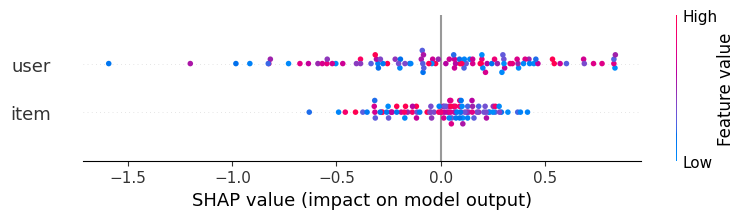

In [25]:
# SHAP Explainer for the Item-KNN model
explainer = shap.Explainer(item_knn_wrapper.predict, X_shap)

shap_values = explainer(X_shap)

shap.summary_plot(shap_values, X_shap)

In [29]:
# select a specific sample
sample = sample_data.iloc[0]

# extract user and item
user_id = sample['user']
item_id = sample['item']

# generate SHAP values
shap_values_single = explainer(np.array([[user_id, item_id]]))

# initialize SHAP's JavaScript visualization
shap.initjs()

# generate the force plot
shap.force_plot(
    shap_values_single.base_values[0],
    shap_values_single.values[0],
    features=np.array([user_id, item_id]),
    feature_names=['user', 'item']
)

In [31]:
import time

# measure time for SHAP computations
start_time = time.time()

shap_values_sample = explainer(X_shap) 

end_time = time.time()

shap_time_taken = end_time - start_time
print(f"Time taken to compute SHAP values for sample: {shap_time_taken:.2f} seconds")

ExactExplainer explainer: 101it [00:16,  2.22it/s]                                                                     

Time taken to compute SHAP values for sample: 16.19 seconds


In [37]:
# ensure X_shap has the correct number of samples (100)
print(f"X_shap shape: {X_shap.shape}")

# train the surrogate decision tree model on SHAP input data
surrogate_model.fit(X_shap, original_predictions)

# generate predictions using the surrogate model
surrogate_predictions = surrogate_model.predict(X_shap).flatten()

# check lengths of both predictions
print(f"Original predictions length: {len(original_predictions)}")
print(f"Surrogate predictions length: {len(surrogate_predictions)}")

# calculate RMSE between original and surrogate predictions
if len(original_predictions) == len(surrogate_predictions):
    fidelity_rmse = mean_squared_error(original_predictions, surrogate_predictions, squared=False)
    print(f"Fidelity RMSE: {fidelity_rmse:.4f}")
else:
    print("Error: The number of samples between original and surrogate predictions do not match.")


X_shap shape: (100, 2)
Original predictions length: 100
Surrogate predictions length: 100
Fidelity RMSE between original model and surrogate model: 0.5007


C:\Users\vnguno\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [34]:
# complexity of the Item-KNN model
n_neighbors = algo.k 
n_users = train_data['user'].nunique() 
n_items = train_data['item'].nunique() 

print(f"Model Complexity: {n_neighbors} neighbors, {n_users} users, {n_items} items")

Model Complexity: 40 neighbors, 6040 users, 3683 items


In [38]:
import shap
import numpy as np

# wrapper for the ALS (SVD) model
class ALSModelWrapper:
    def __init__(self, model):
        self.model = model
        
    def predict(self, data):
        predictions = []
        for _, row in data.iterrows():
            user_id = row['user']
            item_id = row['item']
            predicted_rating = self.model.predict(user_id, item_id, r_ui=4, verbose=False).est
            predictions.append(predicted_rating)
        return np.array(predictions)

als_wrapper = ALSModelWrapper(als_algo) 

In [39]:
# small sample of the test data 
sample_data_als = test_data.sample(100)  

X_shap_als = sample_data_als[['user', 'item']]

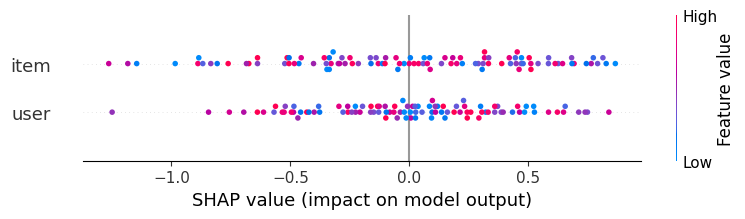

In [40]:
# SHAP Explainer for the ALS (SVD) model
explainer_als = shap.Explainer(als_wrapper.predict, X_shap_als)

shap_values_als = explainer_als(X_shap_als)

shap.summary_plot(shap_values_als, X_shap_als)

In [41]:
# select a specific sample for explanation
sample_als = sample_data_als.iloc[0]

# extract user and item
user_id_als = sample_als['user']
item_id_als = sample_als['item']

# generate SHAP values for this specific sample
shap_values_single_als = explainer_als(np.array([[user_id_als, item_id_als]]))

# initialize SHAP's JavaScript visualization
shap.initjs()

# generate the force plot for the selected sample
shap.force_plot(
    shap_values_single_als.base_values[0],
    shap_values_single_als.values[0],
    features=np.array([user_id_als, item_id_als]),
    feature_names=['user', 'item']
)


In [42]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# generate predictions using the ALS model wrapper 
original_predictions_als = als_wrapper.predict(X_shap_als)

surrogate_model_als = DecisionTreeRegressor(max_depth=3)
surrogate_model_als.fit(X_shap_als, original_predictions_als)  

surrogate_predictions_als = surrogate_model_als.predict(X_shap_als)

fidelity_rmse_als = mean_squared_error(original_predictions_als, surrogate_predictions_als, squared=False)
print(f"Fidelity RMSE between ALS model and surrogate model: {fidelity_rmse_als:.4f}")

Fidelity RMSE between ALS model and surrogate model: 0.6276


C:\Users\vnguno\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [43]:
# Model Complexity for ALS (SVD)
n_users_als = train_data['user'].nunique()  # Number of unique users
n_items_als = train_data['item'].nunique()  # Number of unique items

# Display the model complexity
print(f"Model Complexity for ALS: {n_users_als} users, {n_items_als} items")

Model Complexity for ALS: 6040 users, 3683 items


In [141]:
class ContentBasedWrapper:
    def __init__(self, cosine_sim_matrix, top_n_similar_movies):
        self.similarity_matrix = cosine_sim_matrix
        self.top_n_similar_movies = top_n_similar_movies
        
    def predict(self, data):
        predictions = []
        
        # Vectorize the item index lookup using the 'item' column
        data['item_idx'] = data['item'].map(movie_id_to_idx)

        # Handle cases where the item is not found (set item_idx to NaN, which we will handle)
        data['item_idx'] = data['item_idx'].fillna(-1).astype(int)
        
        for _, row in data.iterrows():
            user_id = row['user']
            item_idx = row['item_idx']
            
            # If the item is not found in the movie_id_to_idx, return average rating
            if item_idx == -1:
                predictions.append(merged_data['Rating'].mean())
                continue
            
            # Get the movies the user has rated
            user_ratings = merged_data[merged_data['user'] == user_id]

            # Get top-N similar movies to the one in question
            similar_movies = self.top_n_similar_movies[item_idx]

            # Get the user's ratings for movies similar to the one in question
            rated_similar_movies = user_ratings[user_ratings['item'].isin(movies['MovieID'].iloc[similar_movies])]

            if rated_similar_movies.empty:
                # If no similar movies are rated, use the average rating
                predictions.append(merged_data['Rating'].mean())
            else:
                # Compute weighted sum of ratings based on similarity
                weighted_sum = 0
                sim_sum = 0
                for _, user_row in rated_similar_movies.iterrows():
                    other_movie_idx = movie_id_to_idx[user_row['item']]
                    similarity = self.similarity_matrix[item_idx, other_movie_idx]
                    weighted_sum += similarity * user_row['Rating']
                    sim_sum += similarity

                # Append the predicted rating
                if sim_sum == 0:
                    predictions.append(merged_data['Rating'].mean())
                else:
                    predictions.append(weighted_sum / sim_sum)

        return np.array(predictions)

ExactExplainer explainer: 101it [02:24,  1.55s/it]                                                                     


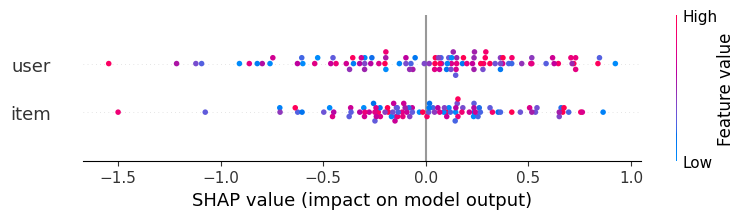

In [69]:
import shap

content_based_wrapper = ContentBasedWrapper(cosine_sim_matrix=cosine_sim, 
                                            top_n_similar_movies=cosine_sim_top_n)

X_shap_cb = test_data[['user', 'item']].sample(100) 

explainer_cb = shap.Explainer(content_based_wrapper.predict, X_shap_cb)

shap_values_cb = explainer_cb(X_shap_cb)

shap.summary_plot(shap_values_cb, X_shap_cb)

In [70]:
sample_index_cb = 0  
sample_cb = X_shap_cb.iloc[sample_index_cb]

user_id_cb = sample_cb['user']
item_id_cb = sample_cb['item']

shap_values_single_cb = explainer_cb(np.array([[user_id_cb, item_id_cb]])) 

shap.initjs()

shap.force_plot(
    shap_values_single_cb.base_values[0],  
    shap_values_single_cb.values[0],  
    features=np.array([user_id_cb, item_id_cb]),  
    feature_names=['user', 'item']
)

In [71]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Generate predictions using the Content-Based model wrapper for SHAP sample data
original_predictions_cb = content_based_wrapper.predict(X_shap_cb)

# Train a surrogate decision tree model on SHAP input data (100 samples)
surrogate_model_cb = DecisionTreeRegressor(max_depth=3)
surrogate_model_cb.fit(X_shap_cb, original_predictions_cb)  # Use original Content-Based predictions as labels

# Generate predictions using the surrogate model
surrogate_predictions_cb = surrogate_model_cb.predict(X_shap_cb)

# Calculate RMSE between the original Content-Based model and the surrogate model
fidelity_rmse_cb = mean_squared_error(original_predictions_cb, surrogate_predictions_cb, squared=False)
print(f"Fidelity RMSE between Content-Based model and surrogate model: {fidelity_rmse_cb:.4f}")

Fidelity RMSE between Content-Based model and surrogate model: 0.7508


C:\Users\vnguno\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [72]:
# Model Complexity for Content-Based Filtering
n_users_cb = train_data['user'].nunique()  
n_items_cb = train_data['item'].nunique()  

print(f"Model Complexity for Content-Based Filtering: {n_users_cb} users, {n_items_cb} items")

Model Complexity for Content-Based Filtering: 6040 users, 3683 items


In [73]:
#lime

In [74]:
import lime
import lime.lime_tabular

# Step 1: Prepare the explainer
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(train_data[['user', 'item']]),  # Use your training data
    mode='regression',  # Since it's predicting ratings
    feature_names=['user', 'item'],
    verbose=True,
    feature_selection='auto'
)

In [75]:
# wrapper for the Item-KNN model
class ItemKNNWrapper:
    def __init__(self, model):
        self.model = model
        
    def predict(self, data):
        # LIME will pass data in a batch, so we iterate through the input data
        predictions = []
        for row in data:
            user_id = row[0]
            item_id = row[1]
            # Predict the rating using the Item-KNN model
            predicted_rating = self.model.predict(user_id, item_id, r_ui=4, verbose=False).est
            predictions.append(predicted_rating)
        return np.array(predictions)

# Initialize the wrapper with your trained Item-KNN model
item_knn_wrapper = ItemKNNWrapper(algo)  # 'algo' is your trained Item-KNN model

In [76]:

sample_index = 0  
sample_user_item = test_data.iloc[sample_index]
user_id = sample_user_item['user']
item_id = sample_user_item['item']

explanation = explainer_lime.explain_instance(
    data_row=np.array([user_id, item_id]),  # Input for the user-item pair
    predict_fn=item_knn_wrapper.predict  # Use the Item-KNN model wrapper
)

# Step 3: Display the explanation
explanation.show_in_notebook(show_table=True)

Intercept 3.5811081018057225
Prediction_local [3.58251091]
Right: 4.221531945782803


In [77]:
import time

start_time = time.time()

explanation = explainer_lime.explain_instance(
    data_row=np.array([user_id, item_id]),  
    predict_fn=item_knn_wrapper.predict  
)

end_time = time.time()

# Calculate the time taken to compute the explanation
lime_time_taken = end_time - start_time
print(f"Time taken to compute LIME explanation for one instance: {lime_time_taken:.4f} seconds")

Intercept 3.581114536145311
Prediction_local [3.58246797]
Right: 4.221531945782803
Time taken to compute LIME explanation for one instance: 0.0780 seconds


In [78]:
# Model Complexity for Item-KNN
n_neighbors_knn = algo.k  
n_users_knn = train_data['user'].nunique()  
n_items_knn = train_data['item'].nunique() 

print(f"Model Complexity for Item-KNN: {n_neighbors_knn} neighbors, {n_users_knn} users, {n_items_knn} items")

Model Complexity for Item-KNN: 40 neighbors, 6040 users, 3683 items


In [79]:
import lime
import lime.lime_tabular

explainer_lime_als = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(train_data[['user', 'item']]),  
    mode='regression',  
    feature_names=['user', 'item'],
    verbose=True,
    feature_selection='auto'
)

In [80]:
# wrapper for the ALS (SVD) model
class ALSWrapper:
    def __init__(self, model):
        self.model = model
        
    def predict(self, data):
        predictions = []
        for row in data:
            user_id = row[0]
            item_id = row[1]
            predicted_rating = self.model.predict(user_id, item_id, r_ui=4, verbose=False).est
            predictions.append(predicted_rating)
        return np.array(predictions)

als_wrapper = ALSWrapper(als_algo)  

In [84]:

sample_index_als = 0  # You can choose any index
sample_user_item_als = test_data.iloc[sample_index_als]
user_id_als = sample_user_item_als['user']
item_id_als = sample_user_item_als['item']

explanation_als = explainer_lime_als.explain_instance(
    data_row=np.array([user_id_als, item_id_als]),  # Input for the user-item pair
    predict_fn=als_wrapper.predict  # Use the ALS model wrapper
)

explanation_als.show_in_notebook(show_table=True)

Intercept 3.5815644093986942
Prediction_local [3.58029495]
Right: 3.0130195024765127


In [85]:
import time

start_time_als = time.time()

explanation_als = explainer_lime_als.explain_instance(
    data_row=np.array([user_id_als, item_id_als]),  
    predict_fn=als_wrapper.predict  
)

end_time_als = time.time()

lime_time_taken_als = end_time_als - start_time_als
print(f"Time taken to compute LIME explanation for one instance: {lime_time_taken_als:.4f} seconds")

Intercept 3.581555546230032
Prediction_local [3.58032668]
Right: 3.0130195024765127
Time taken to compute LIME explanation for one instance: 0.0568 seconds


In [86]:

n_users_als = train_data['user'].nunique() 
n_items_als = train_data['item'].nunique() 

print(f"Model Complexity for ALS: {n_users_als} users, {n_items_als} items")

Model Complexity for ALS: 6040 users, 3683 items


In [87]:
import lime
import lime.lime_tabular

explainer_lime_cb = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(train_data[['user', 'item']]),  # Use your training data
    mode='regression',  # Since it's predicting ratings
    feature_names=['user', 'item'],
    verbose=True,
    feature_selection='auto'
)

In [88]:
# wrapper for the Content-Based Filtering model
class ContentBasedWrapper:
    def __init__(self, model, cosine_sim_matrix, top_n_similar_movies):
        self.similarity_matrix = cosine_sim_matrix
        self.top_n_similar_movies = top_n_similar_movies
        
    def predict(self, data):
        predictions = []
        for row in data:
            user_id = row[0]
            item_id = row[1]
            
            user_ratings = merged_data[merged_data['user'] == user_id]

            if item_id in movie_id_to_idx:
                movie_idx = movie_id_to_idx[item_id]
            else:
                predictions.append(merged_data['Rating'].mean())
                continue
            
            similar_movies = self.top_n_similar_movies[movie_idx]
            
            rated_similar_movies = user_ratings[user_ratings['item'].isin(movies['MovieID'].iloc[similar_movies])]

            if rated_similar_movies.empty:
                predictions.append(merged_data['Rating'].mean())
            else:
                weighted_sum = 0
                sim_sum = 0
                for _, user_row in rated_similar_movies.iterrows():
                    other_movie_idx = movie_id_to_idx[user_row['item']]
                    similarity = self.similarity_matrix[movie_idx, other_movie_idx]
                    weighted_sum += similarity * user_row['Rating']
                    sim_sum += similarity
                
                if sim_sum == 0:
                    predictions.append(merged_data['Rating'].mean())
                else:
                    predictions.append(weighted_sum / sim_sum)

        return np.array(predictions)
        
content_based_wrapper = ContentBasedWrapper(model=None, 
                                            cosine_sim_matrix=cosine_sim, 
                                            top_n_similar_movies=cosine_sim_top_n)

In [89]:

sample_index_cb = 0  # any index
sample_user_item_cb = test_data.iloc[sample_index_cb]
user_id_cb = sample_user_item_cb['user']
item_id_cb = sample_user_item_cb['item']

explanation_cb = explainer_lime_cb.explain_instance(
    data_row=np.array([user_id_cb, item_id_cb]),
    predict_fn=content_based_wrapper.predict 
)

explanation_cb.show_in_notebook(show_table=True)

Intercept 3.5815644530293174
Prediction_local [3.58156445]
Right: 3.581564453029317


In [90]:
import time

start_time_cb = time.time()

explanation_cb = explainer_lime_cb.explain_instance(
    data_row=np.array([user_id_cb, item_id_cb]),  # Input for the user-item pair
    predict_fn=content_based_wrapper.predict  # Use the Content-Based model wrapper
)

end_time_cb = time.time()

lime_time_taken_cb = end_time_cb - start_time_cb
print(f"Time taken to compute LIME explanation for one instance: {lime_time_taken_cb:.4f} seconds")

Intercept 3.581564453029317
Prediction_local [3.58156445]
Right: 3.581564453029317
Time taken to compute LIME explanation for one instance: 11.6088 seconds


In [91]:
# Model Complexity for Content-Based Filtering
n_users_cb = train_data['user'].nunique()  # Number of unique users
n_items_cb = train_data['item'].nunique()  # Number of unique items

# Display the model complexity
print(f"Model Complexity for Content-Based Filtering: {n_users_cb} users, {n_items_cb} items")

Model Complexity for Content-Based Filtering: 6040 users, 3683 items


In [92]:
#counterfactual

In [93]:
import numpy as np

# Define a function to create counterfactuals for Item-KNN
def generate_counterfactual(user_id, item_id, desired_rating, model):
    # Get the current prediction for the user-item pair
    current_prediction = model.predict(user_id, item_id, verbose=False).est

    # Adjust features (either user or item) to reach the desired rating
    # In this case, let's adjust the item to find one that gives the desired rating
    counterfactual_item_id = item_id
    while abs(current_prediction - desired_rating) > 0.1:  # Adjust until we reach close to desired
        counterfactual_item_id = np.random.choice(merged_data['item'].unique())
        current_prediction = model.predict(user_id, counterfactual_item_id, verbose=False).est

    return counterfactual_item_id, current_prediction

# Example usage: Generate a counterfactual for a specific user-item pair
user_id_cf = 5412  # Example user
item_id_cf = 2683  # Example item
desired_rating_cf = 5.0  # Example desired rating

cf_item, cf_prediction = generate_counterfactual(user_id_cf, item_id_cf, desired_rating_cf, algo)
print(f"Counterfactual: Change item {item_id_cf} to {cf_item} to achieve a predicted rating of {cf_prediction:.4f}")

Counterfactual: Change item 2683 to 3172 to achieve a predicted rating of 5.0000


In [107]:
# Find details for the counterfactual item (3172)
cf_item_details = movies[movies['MovieID'] == 3172]
display("Counterfactual item details:")
display(cf_item_details)

# Compare with the original item (2683)
original_item_details = movies[movies['MovieID'] == 2683]
display("Original item details:")
display(original_item_details)

'Counterfactual item details:'

MovieID                    Title     Genres
3103     3172  Ulysses (Ulisse) (1954)  Adventure

'Original item details:'

MovieID                                         Title  Genres
2614     2683  Austin Powers: The Spy Who Shagged Me (1999)  Comedy

In [96]:
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import pairwise_distances

def closeness_to_prediction(x_cf, model, desired_rating, epsilon=0.1):
    prediction = model.predict(int(x_cf[0]), int(x_cf[1]), verbose=False).est
    return abs(prediction - desired_rating)

def gower_distance(x, x_cf, data_range):
    diff = abs(x - x_cf) / data_range
    return np.sum(diff) / len(x)

def sparse_changes(x, x_cf):
    return np.sum(x != x_cf)

def likelihood_of_counterfactual(x_cf, train_data):
    # Calculate similarity to nearest observed data point
    distances = pairwise_distances([x_cf], train_data, metric='euclidean')
    return np.min(distances)

def counterfactual_loss(x_cf, x, model, train_data, desired_rating, data_range, alpha=1.0, beta=1.0, gamma=1.0, delta=1.0):
    return (alpha * closeness_to_prediction(x_cf, model, desired_rating) + 
            beta * gower_distance(x, x_cf, data_range) +
            gamma * sparse_changes(x, x_cf) +
            delta * likelihood_of_counterfactual(x_cf, train_data))

def find_counterfactual(x, model, train_data, desired_rating, data_range):
    # Minimize the combined loss function
    result = minimize(counterfactual_loss, x0=x, args=(x, model, train_data, desired_rating, data_range), method='Nelder-Mead')
    return result.x

x = np.array([5412, 2683])  
desired_rating = 5.0
data_range = np.array([max(train_data['user']) - min(train_data['user']), max(train_data['item']) - min(train_data['item'])])

x_cf = find_counterfactual(x, algo, train_data[['user', 'item']], desired_rating, data_range)
print(f"Counterfactual Instance: User {int(x_cf[0])}, Item {int(x_cf[1])}")

Counterfactual Instance: User 5682, Item 2683


In [100]:

# Filter the ratings for User 5682 and User 5412
user_5682_ratings = ratings[ratings['UserID'] == 5682]
user_5412_ratings = ratings[ratings['UserID'] == 5412]

user_5682_ratings_detailed = pd.merge(user_5682_ratings, movies, on='MovieID')
user_5412_ratings_detailed = pd.merge(user_5412_ratings, movies, on='MovieID')

user_5682_ratings_detailed, user_5412_ratings_detailed

(     UserID  MovieID  Rating                            Title  \
 0      5682     2053       1  Honey, I Blew Up the Kid (1992)   
 1      5682     3793       4                     X-Men (2000)   
 2      5682     2054       5  Honey, I Shrunk the Kids (1989)   
 3      5682     2058       4           Negotiator, The (1998)   
 4      5682     3798       4         What Lies Beneath (2000)   
 ..      ...      ...     ...                              ...   
 603    5682     1089       5            Reservoir Dogs (1992)   
 604    5682     1090       5                   Platoon (1986)   
 605    5682     2042       2      D2: The Mighty Ducks (1994)   
 606    5682     3784       3                  Kid, The (2000)   
 607    5682     3785       5               Scary Movie (2000)   
 
                                          Genres  
 0                      Children's|Comedy|Sci-Fi  
 1                                 Action|Sci-Fi  
 2    Adventure|Children's|Comedy|Fantasy|Sci-Fi  
 3

In [101]:
import time

start_time_cf = time.time()

x_cf = find_counterfactual(x, algo, train_data[['user', 'item']], desired_rating, data_range)

end_time_cf = time.time()

cf_time_taken = end_time_cf - start_time_cf
print(f"Time taken to compute Counterfactual Explanation: {cf_time_taken:.4f} seconds")

Time taken to compute Counterfactual Explanation: 7.1957 seconds


In [102]:
# Model Complexity for Item-KNN
n_neighbors = algo.k  
n_users = train_data['user'].nunique()  
n_items = train_data['item'].nunique()  

print(f"Model Complexity for Item-KNN: {n_neighbors} neighbors, {n_users} users, {n_items} items")

Model Complexity for Item-KNN: 40 neighbors, 6040 users, 3683 items


In [104]:
import time

def find_counterfactual_als(x, model, train_data, desired_rating, data_range):
    # Minimize the combined loss function for ALS
    result = minimize(counterfactual_loss, x0=x, args=(x, model, train_data, desired_rating, data_range), method='Nelder-Mead')
    return result.x

start_time_als = time.time()

x_cf_als = find_counterfactual_als(x, als_algo, train_data[['user', 'item']], desired_rating, data_range)

end_time_als = time.time()

cf_time_taken_als = end_time_als - start_time_als
print(f"Time taken to compute Counterfactual Explanation for ALS: {cf_time_taken_als:.4f} seconds")

n_users_als = train_data['user'].nunique()  
n_items_als = train_data['item'].nunique()  

print(f"Model Complexity for ALS: {n_users_als} users, {n_items_als} items")

Time taken to compute Counterfactual Explanation for ALS: 7.2512 seconds
Model Complexity for ALS: 6040 users, 3683 items


In [106]:
from scipy.optimize import minimize
import numpy as np

def closeness_to_prediction_als(x_cf, model, desired_rating):
    user_id = int(x_cf[0])
    item_id = int(x_cf[1])
    prediction = model.predict(user_id, item_id).est
    return abs(prediction - desired_rating)

def gower_distance(x, x_cf, data_range):
    diff = abs(x - x_cf) / data_range
    return np.sum(diff) / len(x)

def sparse_changes(x, x_cf):
    return np.sum(x != x_cf)

def likelihood_of_counterfactual(x_cf, train_data):
    distances = pairwise_distances([x_cf], train_data, metric='euclidean')
    return np.min(distances)

def counterfactual_loss_als(x_cf, x, model, train_data, desired_rating, data_range, alpha=1.0, beta=1.0, gamma=1.0, delta=1.0):
    return (alpha * closeness_to_prediction_als(x_cf, model, desired_rating) + 
            beta * gower_distance(x, x_cf, data_range) +
            gamma * sparse_changes(x, x_cf) +
            delta * likelihood_of_counterfactual(x_cf, train_data))

def find_counterfactual_als(x, model, train_data, desired_rating, data_range):
    result = minimize(counterfactual_loss_als, x0=x, args=(x, model, train_data, desired_rating, data_range), method='Nelder-Mead')
    return result.x

x = np.array([5412, 2683])  
desired_rating = 5.0  # Desired rating
data_range = np.array([max(train_data['user']) - min(train_data['user']), max(train_data['item']) - min(train_data['item'])])

# Step 3: Find the counterfactual for ALS
x_cf_als = find_counterfactual_als(x, als_algo, train_data[['user', 'item']], desired_rating, data_range)
print(f"Counterfactual Instance for ALS: User {int(x_cf_als[0])}, Item {int(x_cf_als[1])}")

Counterfactual Instance for ALS: User 5682, Item 2683


In [119]:
import pandas as pd
from scipy.optimize import minimize
import numpy as np

def closeness_to_prediction_cb(x_cf, model, desired_rating):

    user_item_df = pd.DataFrame({'user': [int(x_cf[0])], 'item': [int(x_cf[1])]})
    
    prediction = model.predict(user_item_df)  
    
    return abs(prediction[0] - desired_rating)

def counterfactual_loss_cb(x_cf, x, model, train_data, desired_rating, data_range, alpha=1.0, beta=1.0, gamma=1.0, delta=1.0):
    return (alpha * closeness_to_prediction_cb(x_cf, model, desired_rating) + 
            beta * gower_distance(x, x_cf, data_range) +
            gamma * sparse_changes(x, x_cf) +
            delta * likelihood_of_counterfactual(x_cf, train_data))

def find_counterfactual_cb(x, model, train_data, desired_rating, data_range):
    result = minimize(counterfactual_loss_cb, x0=x, args=(x, model, train_data, desired_rating, data_range), method='Nelder-Mead')
    return result.x

x = np.array([5412, 2683]) 
desired_rating = 5.0  # Desired rating
data_range = np.array([max(train_data['user']) - min(train_data['user']), max(train_data['item']) - min(train_data['item'])])

x_cf_cb = find_counterfactual_cb(x, content_based_wrapper, train_data[['user', 'item']], desired_rating, data_range)

print(f"Counterfactual Instance for Content-Based Filtering: User {int(x_cf_cb[0])}, Item {int(x_cf_cb[1])}")

Counterfactual Instance for Content-Based Filtering: User 5614, Item 2683


In [120]:
import time

start_time_cb = time.time()

x_cf_cb = find_counterfactual_cb(x, content_based_wrapper, train_data[['user', 'item']], desired_rating, data_range)

end_time_cb = time.time()

cf_time_taken_cb = end_time_cb - start_time_cb
print(f"Time taken to compute Counterfactual Explanation for Content-Based Filtering: {cf_time_taken_cb:.4f} seconds")

Time taken to compute Counterfactual Explanation for Content-Based Filtering: 5.4702 seconds


In [121]:
# Model Complexity for Content-Based Filtering
n_users_cb = train_data['user'].nunique()  
n_items_cb = train_data['item'].nunique()  

print(f"Model Complexity for Content-Based Filtering: {n_users_cb} users, {n_items_cb} items")

Model Complexity for Content-Based Filtering: 6040 users, 3683 items


In [94]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

def train_surrogate_model(data, model):
    X = data[['user', 'item']]
    y = [model.predict(row['user'], row['item'], verbose=False).est for _, row in data.iterrows()]

    # Train a decision tree surrogate model
    surrogate_model = DecisionTreeRegressor(max_depth=3)
    surrogate_model.fit(X, y)
    
    return surrogate_model

surrogate_model_knn = train_surrogate_model(test_data, algo)

y_pred_surrogate = surrogate_model_knn.predict(test_data[['user', 'item']])
y_true_knn = [algo.predict(row['user'], row['item'], verbose=False).est for _, row in test_data.iterrows()]

surrogate_rmse = mean_squared_error(y_true_knn, y_pred_surrogate, squared=False)
print(f"Surrogate Model RMSE for Item-KNN: {surrogate_rmse:.4f}")

Surrogate Model RMSE for Item-KNN: 0.5113


C:\Users\vnguno\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


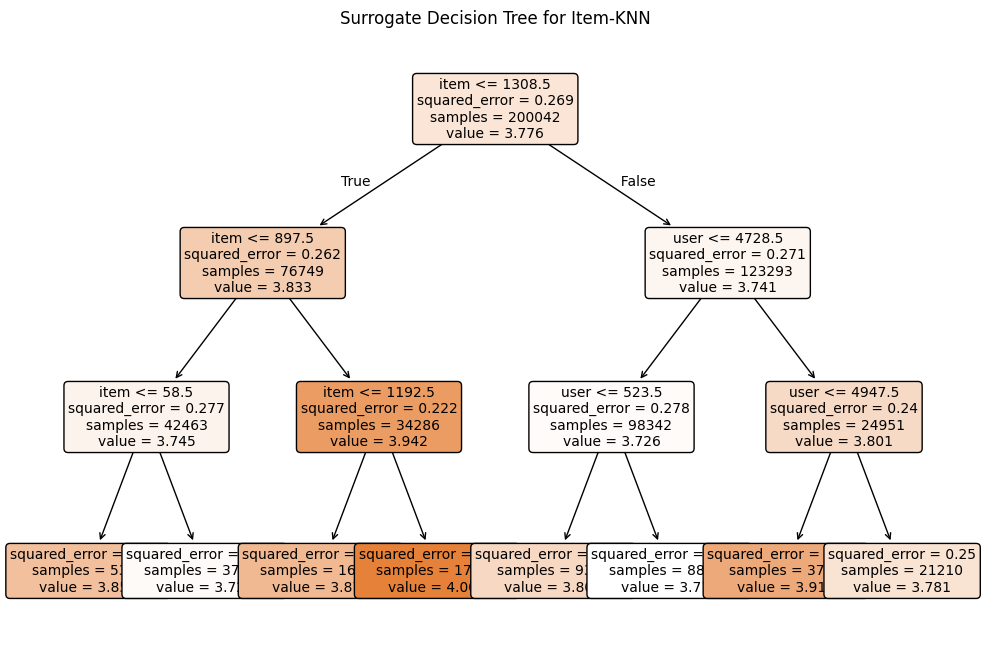

In [122]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(12, 8))
plot_tree(surrogate_model_knn, feature_names=['user', 'item'], filled=True, rounded=True, fontsize=10)
plt.title("Surrogate Decision Tree for Item-KNN")
plt.show()

In [123]:
import time

start_time_surrogate = time.time()

surrogate_model_knn = train_surrogate_model(test_data, algo)

y_pred_surrogate = surrogate_model_knn.predict(test_data[['user', 'item']])

end_time_surrogate = time.time()

time_taken_surrogate = end_time_surrogate - start_time_surrogate
print(f"Time taken to train and evaluate Surrogate Model for Item-KNN: {time_taken_surrogate:.4f} seconds")

Time taken to train and evaluate Surrogate Model for Item-KNN: 60.3693 seconds


In [124]:

tree_depth = surrogate_model_knn.get_depth()
tree_nodes = surrogate_model_knn.get_n_leaves()

# Display tree complexity
print(f"Surrogate Model Tree Depth: {tree_depth}")
print(f"Surrogate Model Number of Leaves: {tree_nodes}")

n_neighbors_knn = algo.k  
n_users_knn = train_data['user'].nunique() 
n_items_knn = train_data['item'].nunique() 

print(f"Model Complexity for Item-KNN: {n_neighbors_knn} neighbors, {n_users_knn} users, {n_items_knn} items")

Surrogate Model Tree Depth: 3
Surrogate Model Number of Leaves: 8
Model Complexity for Item-KNN: 40 neighbors, 6040 users, 3683 items


In [125]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import time

def train_surrogate_model_als(data, model):
    X = data[['user', 'item']]
    y = [model.predict(row['user'], row['item'], verbose=False).est for _, row in data.iterrows()]

    # Train a decision tree surrogate model
    surrogate_model = DecisionTreeRegressor(max_depth=3)
    surrogate_model.fit(X, y)
    
    return surrogate_model

start_time_surrogate_als = time.time()

surrogate_model_als = train_surrogate_model_als(test_data, algo)

y_pred_surrogate_als = surrogate_model_als.predict(test_data[['user', 'item']])
y_true_als = [algo.predict(row['user'], row['item'], verbose=False).est for _, row in test_data.iterrows()]

end_time_surrogate_als = time.time()

surrogate_rmse_als = mean_squared_error(y_true_als, y_pred_surrogate_als, squared=False)

time_taken_surrogate_als = end_time_surrogate_als - start_time_surrogate_als

print(f"Surrogate Model RMSE for ALS: {surrogate_rmse_als:.4f}")
print(f"Time taken to train and evaluate Surrogate Model for ALS: {time_taken_surrogate_als:.4f} seconds")

tree_depth_als = surrogate_model_als.get_depth()
tree_nodes_als = surrogate_model_als.get_n_leaves()

print(f"Surrogate Model Tree Depth for ALS: {tree_depth_als}")
print(f"Surrogate Model Number of Leaves for ALS: {tree_nodes_als}")

n_users_als = train_data['user'].nunique()  
n_items_als = train_data['item'].nunique()  

print(f"Model Complexity for ALS: {n_users_als} users, {n_items_als} items")

Surrogate Model RMSE for ALS: 0.5113
Time taken to train and evaluate Surrogate Model for ALS: 112.1944 seconds
Surrogate Model Tree Depth for ALS: 3
Surrogate Model Number of Leaves for ALS: 8
Model Complexity for ALS: 6040 users, 3683 items


C:\Users\vnguno\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


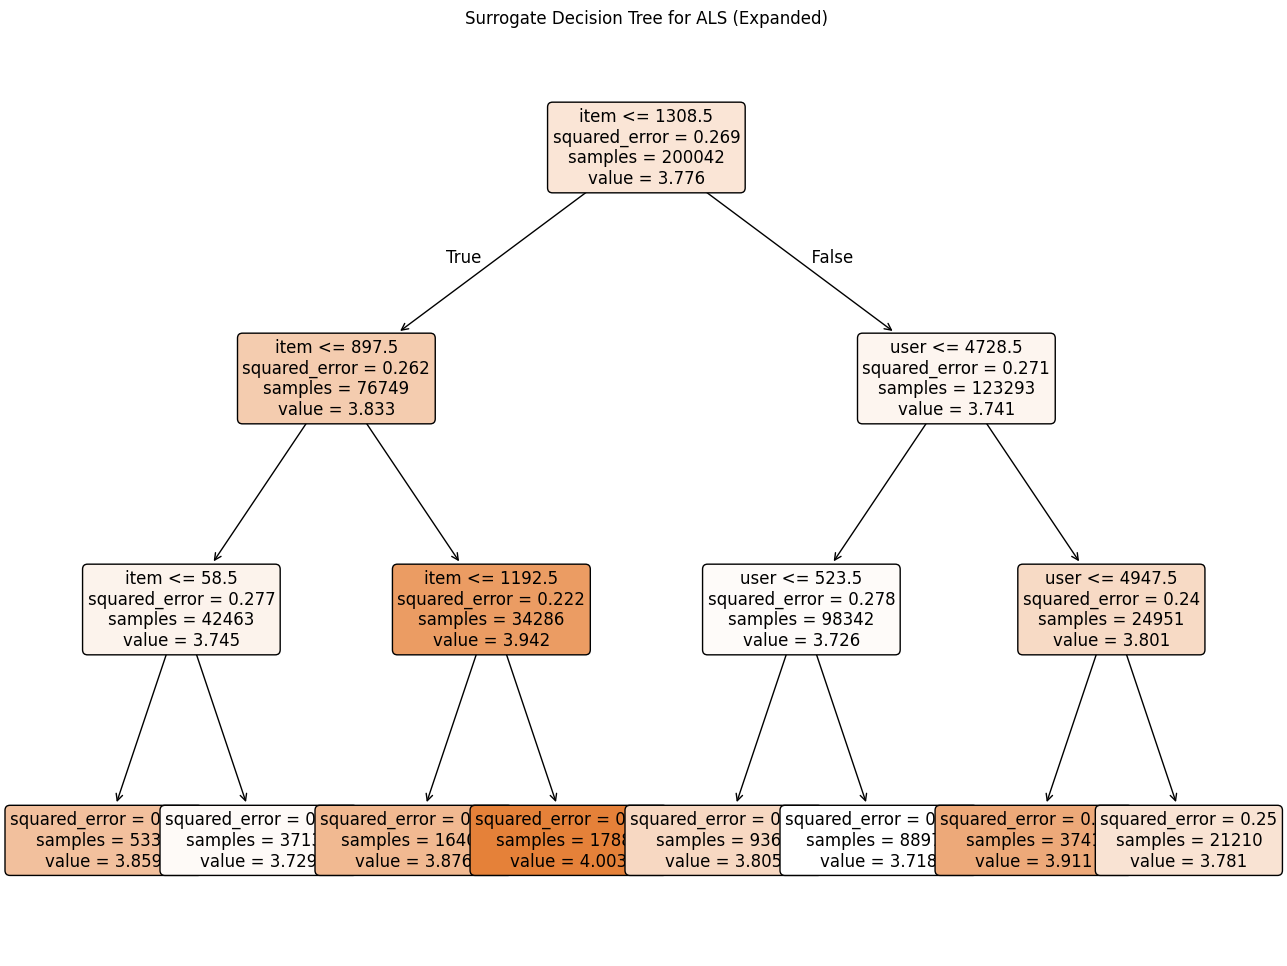

In [128]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(16, 12))  

plot_tree(surrogate_model_als, feature_names=['user', 'item'], filled=True, rounded=True, fontsize=12)

plt.title("Surrogate Decision Tree for ALS (Expanded)")
plt.show()

In [150]:
class ContentBasedWrapper2:
    def __init__(self, cosine_sim_matrix, top_n_similar_movies):
        self.similarity_matrix = cosine_sim_matrix
        self.top_n_similar_movies = top_n_similar_movies
        
    def predict(self, data):
        predictions = []
        
        data = data.copy() 
        data.loc[:, 'item_idx'] = data['item'].map(movie_id_to_idx)

        data.loc[:, 'item_idx'] = data['item_idx'].fillna(-1).astype(int)
        
        for _, row in data.iterrows():
            user_id = row['user']
            item_idx = row['item_idx']
            
            if item_idx == -1:
                predictions.append(merged_data['Rating'].mean())
                continue
            
            user_ratings = merged_data[merged_data['user'] == user_id]

            similar_movies = self.top_n_similar_movies[item_idx]

            rated_similar_movies = user_ratings[user_ratings['item'].isin(movies['MovieID'].iloc[similar_movies])]

            if rated_similar_movies.empty:
                predictions.append(merged_data['Rating'].mean())
            else:
                weighted_sum = 0
                sim_sum = 0
                for _, user_row in rated_similar_movies.iterrows():
                    other_movie_idx = movie_id_to_idx[user_row['item']]
                    similarity = self.similarity_matrix[item_idx, other_movie_idx]
                    weighted_sum += similarity * user_row['Rating']
                    sim_sum += similarity

                if sim_sum == 0:
                    predictions.append(merged_data['Rating'].mean())
                else:
                    predictions.append(weighted_sum / sim_sum)

        return np.array(predictions)


In [151]:
# Create an instance of ContentBasedWrapper2
content_based_wrapper2 = ContentBasedWrapper2(cosine_sim_matrix=cosine_sim, top_n_similar_movies=cosine_sim_top_n)

# Train the surrogate model using the instance
surrogate_model_cb = train_surrogate_model_cb(test_data, content_based_wrapper2)

# Make predictions using the surrogate model
y_pred_surrogate_cb = surrogate_model_cb.predict(test_data[['user', 'item']])

# Make true predictions using the content-based filtering model (instance)
y_true_cb = content_based_wrapper2.predict(test_data[['user', 'item']])

# Calculate RMSE between the true predictions and surrogate model predictions
surrogate_rmse_cb = mean_squared_error(y_true_cb, y_pred_surrogate_cb, squared=False)
print(f"Surrogate Model RMSE for Content-Based Filtering: {surrogate_rmse_cb:.4f}")

Surrogate Model RMSE for Content-Based Filtering: 0.7654


C:\Users\vnguno\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [152]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import time

def train_surrogate_model_cb(data, model):
    X = data[['user', 'item']]
    y = model.predict(data)  

    # Train a decision tree surrogate model
    surrogate_model = DecisionTreeRegressor(max_depth=3)
    surrogate_model.fit(X, y)
    
    return surrogate_model

start_time_surrogate_cb = time.time()

surrogate_model_cb = train_surrogate_model_cb(test_data, content_based_wrapper2)

y_pred_surrogate_cb = surrogate_model_cb.predict(test_data[['user', 'item']])
y_true_cb = content_based_wrapper2.predict(test_data[['user', 'item']])

end_time_surrogate_cb = time.time()

surrogate_rmse_cb = mean_squared_error(y_true_cb, y_pred_surrogate_cb, squared=False)

time_taken_surrogate_cb = end_time_surrogate_cb - start_time_surrogate_cb

print(f"Surrogate Model RMSE for Content-Based Filtering: {surrogate_rmse_cb:.4f}")
print(f"Time taken to train and evaluate Surrogate Model for Content-Based Filtering: {time_taken_surrogate_cb:.4f} seconds")

tree_depth_cb = surrogate_model_cb.get_depth()
tree_nodes_cb = surrogate_model_cb.get_n_leaves()

print(f"Surrogate Model Tree Depth for Content-Based Filtering: {tree_depth_cb}")
print(f"Surrogate Model Number of Leaves for Content-Based Filtering: {tree_nodes_cb}")

n_users_cb = train_data['user'].nunique() 
n_items_cb = train_data['item'].nunique()  

print(f"Model Complexity for Content-Based Filtering: {n_users_cb} users, {n_items_cb} items")


Surrogate Model RMSE for Content-Based Filtering: 0.7654
Time taken to train and evaluate Surrogate Model for Content-Based Filtering: 2110.5413 seconds
Surrogate Model Tree Depth for Content-Based Filtering: 3
Surrogate Model Number of Leaves for Content-Based Filtering: 8
Model Complexity for Content-Based Filtering: 6040 users, 3683 items


C:\Users\vnguno\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


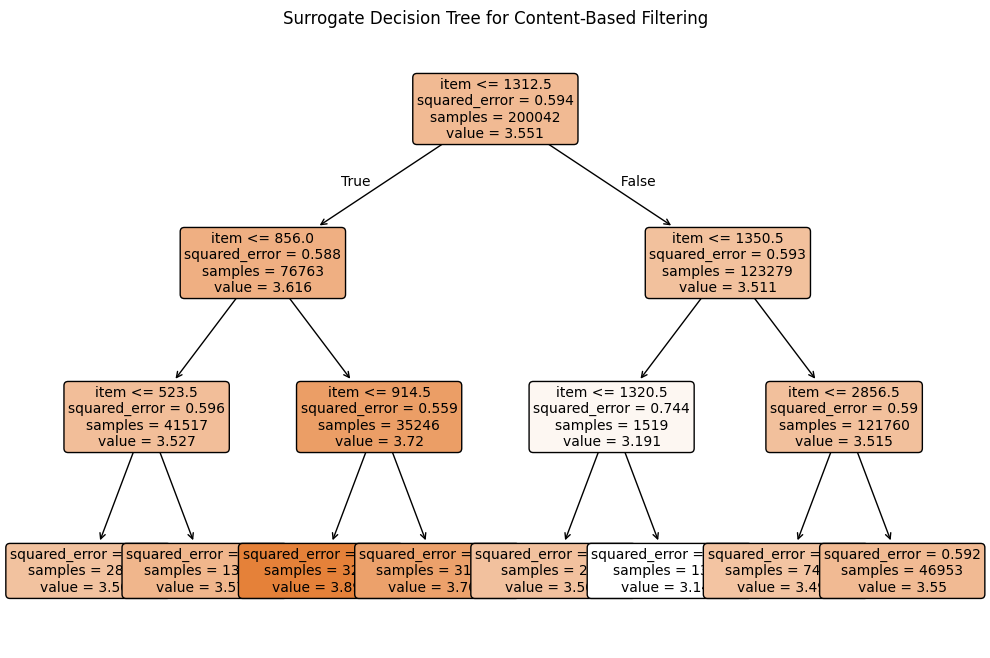

In [153]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8)) 

plot_tree(surrogate_model_cb, feature_names=['user', 'item'], filled=True, rounded=True, fontsize=10)

plt.title("Surrogate Decision Tree for Content-Based Filtering")

# Show the plot
plt.show()